In [177]:
# REQUIREMENTS
# pip install apache-iotdb matplotlib mplcursors scipy

###############################
# IoTDB measurement definitions
###############################

# root.circles100.vehicle_{#}.{YYYY}_{MM}_{DD}.run_{#}.
# gps_data_Gpstime
# gps_data_Status
# gps_data_Long
# gps_data_Lat
# gps_data_Alt
# gps_data_HDOP
# gps_data_PDOP
# gps_data_VDOP
# accel_x_accel_x
# acc_hub_set_speed
# acc_hub_set_distance
# acc_pedal_position_acc_pedal_position
# cruise_state_cruise_state
# odometer_odometer
# speed_speed
# steering_wheel_steer_rate
# steering_wheel_steer_angle

In [178]:
from iotdb.Session import Session
import time
import pandas as pd
from datetime import timedelta
import mplcursors
import gps2postmile
import numpy as np
from scipy.spatial import cKDTree
from math import radians, sin, cos, sqrt, atan2
import bisect

In [179]:
#############
# variables
#############
host=""
port=""
user=""
password=""

datenode='2022_11_17'

date='2022-11-17'
#startTime='08:00:00'
#endTime='08:10:01'
startTime='07:00:00'
endTime='08:59:59'
window=f'[{date}T{startTime},{date}T{endTime})'
chunks='5s'

groupby=f' group by ({window}, {chunks}) '
align=' align by device '
vehicle='*'

select='select avg(acc_hub_set_speed) - avg(speed_speed)*0.621371'
where='where cruise_state_cruise_state > 0 and acc_hub_set_speed between 0 and 120'

session = Session(host,port,user,password)
session.open(False)

#count_records_for_date(session,experiment,date,measurement)

In [180]:
def count_records_for_date(session, date, measurement):
    # Prepare the SQL query using the date parameter
    query = f"SELECT COUNT({measurement}) FROM root.circles100.*.{date}.* group by level = 1"
    df = do_query(session, query)
    display(df)

In [181]:
def do_query(session, query):
    t1 = time.perf_counter()
    print(query)
    try:
        data_set = session.execute_query_statement(query)
        t2 = time.perf_counter()
        df = data_set.todf()
        t3 = time.perf_counter()
        print(len(df),'records in',t2-t1,'seconds', 'dataframe conversion in',t3-t2, 'seconds')
        return df
    except Exception as e:
        print(f"Error querying IoTDB: {e}")

In [182]:
def haversine(lat1, lon1, lat2, lon2):
    # Radius of the Earth in miles
    R = 3958.8
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat / 2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

In [183]:
def find_nearest_postmile(pm_df, lat, lon):
    # Calculate distances to each point in the CSV
    df = pm_df.copy()
    df['distance'] = df.apply(lambda row: haversine(lat, lon, row['latitude'], row['longitude']), axis=1)
    # Find the two closest points in the CSV
    closest_points = df.nsmallest(2, 'distance')
    if closest_points.shape[0] < 2:
        return None  # Not enough points to interpolate
    # Extract lat, lon, and postmile of the two closest points
    lat1, lon1, postmile1 = closest_points.iloc[0][['latitude', 'longitude', 'calculated_mm']]
    lat2, lon2, postmile2 = closest_points.iloc[1][['latitude', 'longitude', 'calculated_mm']]
    # Calculate distances from the new point to the two closest points
    d1 = closest_points.iloc[0]['distance']
    d2 = closest_points.iloc[1]['distance']

    # Linear interpolation of postmile based on inverse distance weighting
    if d1 + d2 == 0:
        interpolated_postmile = (postmile1 + postmile2)/2  # If distances are zero, avoid division by zero
        rd = d1
    else:
        interpolated_postmile = (postmile1 * (1 - d1 / (d1 + d2)) + postmile2 * (1 - d2 / (d1 + d2)))
        rd = min(d1, d2)
        
    return interpolated_postmile,rd

In [184]:
def gps2postmile(df):
    # read in postmile locations
    pm_df = pd.read_csv('link_mm_locations.csv')
    pm_df = pm_df[pm_df['road_side'] == 'w']
    # Apply the function to each row
    df[['Mile Marker', 'Distance to Mile Marker']] = df.apply(
        lambda row: pd.Series(find_nearest_postmile(pm_df, row['Lat'], row['Long'])), axis=1
    )
    return df

In [185]:
def spatial_interpolation(df):
    pm_df = pd.read_csv('link_mm_locations.csv')
    pm_df = pm_df[pm_df['road_side'] == 'w']
    
    # We have to filter out NaN for the following to work...
    df = df.dropna(subset=['Lat', 'Long', 'Bearing'])
    ##### ChatGPT spatial method #####
    # Create KDTree for pm_df
    tree = cKDTree(np.radians(pm_df[['latitude', 'longitude']].to_numpy()))

    # Query two closest neighbors for all rows in df4
    k=2 # Only use the two nearest
    distances, indices = tree.query(np.radians(df[['Lat', 'Long']].to_numpy()), k=k)

    # Calculate weights using inverse distances
    with np.errstate(divide='ignore'):
        weights = 1 / distances
        weights[distances == 0] = 1  # Handle exact matches
        weights = weights / weights.sum(axis=1, keepdims=True)

    # Interpolate mile_marker using weights
    interpolated_mile_markers = np.sum(weights * pm_df['calculated_mm'].values[indices], axis=1)

    df['Mile Marker'] = interpolated_mile_markers

    # Add the distance to the selected mile marker to df
    # Use the minimum distance from the neighbors (smallest in the 'distances' array)
    df['Distance to Mile Marker'] = distances[:, 0] * 3959  # Take the smallest distance (first column of distances)
    ##### end ChatGPT spatial method #####
    return df

In [186]:
# Helper function to calculate the bearing between two points
def calculate_bearing(lat1, lon1, lat2, lon2):
    # Convert degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    # Compute the bearing
    dlon = lon2 - lon1
    x = np.sin(dlon) * np.cos(lat2)
    y = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(dlon)
    initial_bearing = np.arctan2(x, y)
    
    # Convert the bearing from radians to degrees and normalize it
    bearing = np.degrees(initial_bearing)
    bearing = (bearing + 360) % 360  # Normalize to 0-360 range
    
    return bearing

In [187]:
def spatial_interpolation2(df):
    # We will generate our own Bearing column since atan2 is available in Python
    # Helper function to calculate the bearing between two points
    
    # Convert degrees to radians
#    lat1, lon1, lat2, lon2 = map(np.radians, [df['Lat1'], df['Lon1'], df['Lat2'], df['Lon2']])
    
    # Compute the bearing
#    dlon = lon2 - lon1
#    x = np.sin(dlon) * np.cos(lat2)
#    y = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(dlon)
#    initial_bearing = np.arctan2(x, y)
    
    # Convert the bearing from radians to degrees and normalize it
#    bearing = np.degrees(initial_bearing)
#    df['Bearing'] = (bearing + 360) % 360  # Normalize to 0-360 range
    df['Bearing'] = calculate_bearing(df['Lat1'], df['Lon1'], df['Lat2'], df['Lon2'])
    df['Lat'] = (df['Lat1']+df['Lat2'])/2
    df['Long'] = (df['Lon1']+df['Lon2'])/2

    # Load mile marker data
    pm_df = pd.read_csv('link_mm_locations.csv')
    pm_df = pm_df[pm_df['road_side'] == 'w'].copy()
    
    # Drop rows with missing Lat, Long, Bearing
    df = df.dropna(subset=['Lat', 'Long', 'Bearing']).copy()
    
    # Convert Lat/Long to radians for calculations
    query_points = np.radians(df[['Lat', 'Long']].to_numpy())
    ref_points = np.radians(pm_df[['latitude', 'longitude']].to_numpy())
    
    # Create KDTree for fast neighbor searches
    tree = cKDTree(ref_points)
    
    # Query the 4 nearest neighbors
    k = 4
    distances, indices = tree.query(query_points, k=k)
    
    # Get the coordinates of the 4 nearest neighbors
    nearest_coords = ref_points[indices]  # Shape: (query_points, 4 neighbors, 2 coordinates)

    # Compute bearings for the 4 nearest neighbors
    lat1 = query_points[:, 0]  # Query latitudes
    lon1 = query_points[:, 1]  # Query longitudes
    lat2 = nearest_coords[:, :, 0]  # Nearest neighbor latitudes
    lon2 = nearest_coords[:, :, 1]  # Nearest neighbor longitudes
    
    # Compute the relative bearings
    delta_lon = lon2 - lon1[:, None]
    x = np.sin(delta_lon) * np.cos(lat2)
    y = np.cos(lat1[:, None]) * np.sin(lat2) - np.sin(lat1[:, None]) * np.cos(lat2) * np.cos(delta_lon)
    bearings = (np.degrees(np.arctan2(x, y)) % 360)  # Shape: (query_points, 4 neighbors)

    # Compute relative bearings (adjusted to vehicle bearing)
    relative_bearings = (bearings - df['Bearing'].values[:, None] + 360) % 360
    
    # Classify neighbors as left or right
    left_mask = (relative_bearings > 90) & (relative_bearings < 270)  # Left points
    right_mask = ~left_mask  # Right points
    
    # Initialize placeholders for the closest left and right neighbors
    left_indices = np.full(len(df), -1)
    right_indices = np.full(len(df), -1)
    left_distances = np.full(len(df), np.inf)
    right_distances = np.full(len(df), np.inf)

    # Find the closest left and right neighbors
    for i in range(k):
        is_left = left_mask[:, i]
        is_right = right_mask[:, i]

        closer_left = is_left & (distances[:, i] < left_distances)
        closer_right = is_right & (distances[:, i] < right_distances)

        left_indices[closer_left] = indices[closer_left, i]
        left_distances[closer_left] = distances[closer_left, i]

        right_indices[closer_right] = indices[closer_right, i]
        right_distances[closer_right] = distances[closer_right, i]
    
    # Assign left and right markers
    left_markers = np.full(len(df), np.nan)
    right_markers = np.full(len(df), np.nan)
    valid_left = left_indices != -1
    valid_right = right_indices != -1

    if valid_left.any():
        left_markers[valid_left] = pm_df.iloc[left_indices[valid_left]]['calculated_mm'].values
    if valid_right.any():
        right_markers[valid_right] = pm_df.iloc[right_indices[valid_right]]['calculated_mm'].values

    # Convert to miles
    left_distances = left_distances  * 3959
    right_distances = right_distances  * 3959
    
    # Interpolate mile markers using distances
    total_distances = left_distances + right_distances
    interpolated_markers = (left_markers * right_distances + right_markers * left_distances) / total_distances
    
    # Calculate the projection distance along the road using the optimized formula
    #d_proj = (left_distances**2 + (right_markers-left_markers)**2 - right_distances**2) / (2 * (right_markers-left_markers))
    
    # Interpolate the mile marker position
    #interpolated_markers = left_markers + d_proj#(d_proj / (right_markers-left_markers)) * (right_markers - left_markers)

    # Assign the interpolated values to the DataFrame
    df['Mile Marker'] = interpolated_markers
    df['Left Mile Marker'] = left_markers
    df['Right Mile Marker'] = right_markers
    df['Left Distance'] = left_distances
    df['Right Distance'] = right_distances
    return df

In [188]:
def scatter_plot(df):
    import matplotlib.pyplot as plt
    import pandas as pd
    import matplotlib.dates as mdates
    
    # Assuming df is already prepared as in the original code
    speeds = df['Speed'].values  # Speeds for coloring the points
    
    # Set y limits for the trajectory data
    df['observation_datetime'] = pd.to_datetime(df['Time'], unit='us')
    df['observation_datetime_num'] = mdates.date2num(df['observation_datetime'])
    
    # Set x limits for the trajectory data
    xmin, xmax = df['observation_datetime'].min(), df['observation_datetime'].max()
    ymin, ymax = df['Mile Marker'].min(), df['Mile Marker'].max()
    
    # Create figure
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    
    # Create scatter plot
    sc = ax.scatter(
        df['observation_datetime'],  # X-axis (Time)
        df['Mile Marker'],           # Y-axis (Mile Marker)
        c=speeds,                     # Color based on speed
        cmap='viridis',               # Colormap for speed
        s=10,                         # Size of the scatter points
        edgecolor='none'              # No border for points
    )
    
    # Add colorbar
    axcb = fig.colorbar(sc)
    axcb.set_label('Speed (mph)')
    
    # Title and labels
    ax.set_title('Time-space diagram (Scatter)')
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d %H:%M:%S'))
    plt.xticks(rotation=90, ha='right')
    ax.set_xlabel('Time')
    ax.set_ylabel('Mile Marker')
    
    # Adjust layout and save figure
    plt.tight_layout()
    ax.invert_yaxis()
    # plt.savefig(save_path)
    
    plt.show()

In [189]:
def line_plot(df):
    """Generate time-space diagram."""
    from matplotlib import colors
    from matplotlib.collections import LineCollection
    import matplotlib.dates as mdates
    import matplotlib.pyplot as plt
    import pandas as pd
    from mpl_toolkits.mplot3d import Axes3D
    
    speeds = df['Speed'].values # * 2.23694 # Ours are already in MPH (or should be)
    
    # Set y limits for the trajectory data
    df['observation_datetime'] = pd.to_datetime(df['Time'], unit='us')
    df['observation_datetime_num'] = mdates.date2num(df['Time'])
    
    # Set x limits for the trajectory data
    xmin, xmax = df['observation_datetime'].min(), df['observation_datetime'].max()
    ymin, ymax = df['Mile Marker'].min(), df['Mile Marker'].max()
    
    # compute line segment ends by shifting dataframe by 1 row
    df[['next_pos', 'next_time']] = df.groupby('Device')[['Mile Marker', 'observation_datetime_num']].shift(-1)
    df = df[df['next_time'].notna()]  # Remove NaN rows
    df = df[df['next_time'] > df['observation_datetime_num']]
    segs = df[['observation_datetime_num', 'Mile Marker', 'next_time', 'next_pos']].values.reshape((len(df), 2, 2))
    
    # create figure
    fig, ax = plt.subplots(figsize=(15,10))
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    
    # Define color map for line segments
    cdict = {
        'red': ((0, 0, 0), (0.2, 1, 1), (0.6, 1, 1), (1, 0, 0)),
        'green': ((0, 0, 0), (0.2, 0, 0), (0.6, 1, 1), (1, 1, 1)),
        'blue': ((0, 0, 0), (0.2, 0, 0), (0.6, 0, 0), (1, 0, 0))
    }
    cmap = colors.LinearSegmentedColormap('my_colormap', cdict, 1024)
    
    # Plot line segments
    lc = LineCollection(segs, cmap=cmap, norm=colors.Normalize(vmin=0, vmax=70))
    lc.set_array(speeds)
    lc.set_linewidth(1)
    ax.add_collection(lc)
    
    # Add colorbar
    lc.set_clim(0, 70)
    axcb = fig.colorbar(lc)
    
    # Title and labels
    ax.set_title('Time-space diagram')
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d %H:%M:%S'))
    plt.xticks(rotation=90, ha='right')
    ax.set_xlabel('Time')
    ax.set_ylabel('Mile Marker')
    axcb.set_label('Speed (mph)')
    
    # Save figure
    plt.tight_layout()
    ax.invert_yaxis()

In [219]:
def filter_data(df, NaN=False):
    ### Filtering Options ###
    # ** Note! ** 
    # Filtering vs. replacing with NaN affect the plot. 
    # NaN causes breaks in the plot line whereas filter does not.
    
    ###################################
    # Filter to Westbound and MM Proximity
    ###################################
    if(NaN):
        df.loc[((df['Bearing'] < 225) & (df['Bearing'] > 1)), ['Mile Marker', 'Speed']] = np.nan
    else:
        df = df[(df['Bearing'] > 225) | (df['Bearing'] < 1)]
    #df.loc[(df['Distance to Mile Marker'] > 1.5) | (df['Bearing'] == 0), ['Mile Marker', 'Speed']] = np.nan
    
    ###################################
    # Filter to overlapping highway MM
    ###################################
    if(NaN):
        df.loc[(df['Mile Marker'] < 60.5) | (df['Mile Marker'] > 64.3), ['Speed', 'Mile Marker']] = np.nan
    else:
        df = df[(df['Mile Marker'] > 60.5) & (df['Mile Marker'] < 64.3)]
    ####
    
    ###################################
    # Filter by on/off ramps
    ###################################
    # Our data has cars using to separate sets of on/off ramps.
    # Compute max and min mile markers for each device
    #device_stats = df.groupby('Device')['Mile Marker'].agg(['min', 'max'])
    # Identify devices where the range is outside the specified range
    #valid_devices = device_stats[(device_stats['max'] > 65) & (device_stats['min'] > 59)].index
    # Filter the original dataframe to keep only valid devices
    #df = df[df['Device'].isin(valid_devices)]
    
    # Remove filter columns we no longer need
    #del df['Bearing']
    #del df['Lat']
    #del df['Long']
    #del df['Distance to Mile Marker']
    return df

In [191]:
####################
# Example of counting speed records for a given date
####################

#count_records_for_date(session, '2022_11_17', 'speed_speed')

In [217]:
#####################
# Get acc_hub_set_speed - speed_speed records for all cars/runs in a specific small time window, combined
#####################
query = f'''
SELECT avg(acc_hub_set_speed) - avg(speed_speed)*0.621371
FROM root.circles100.vehicle_8*.2022_11_17.*
WHERE cruise_state_cruise_state > 0 and acc_hub_set_speed between 0 and 120
{groupby} order by Time {align}
'''
df = do_query(session, query)
column = (set(df.columns)-{'Time','Device'}).pop()
df = df.dropna(subset=[column])
df['Time'] = (pd.to_datetime(df['Time'], unit='us') - timedelta(hours=6)).dt.strftime('%H:%M:%S')
#display(df)


SELECT avg(acc_hub_set_speed) - avg(speed_speed)*0.621371
FROM root.circles100.vehicle_8*.2022_11_17.*
WHERE cruise_state_cruise_state > 0 and acc_hub_set_speed between 0 and 120
 group by ([2022-11-17T07:00:00,2022-11-17T08:59:59), 5s)  order by Time  align by device 

47520 records in 0.07972441602032632 seconds dataframe conversion in 0.0838077089865692 seconds


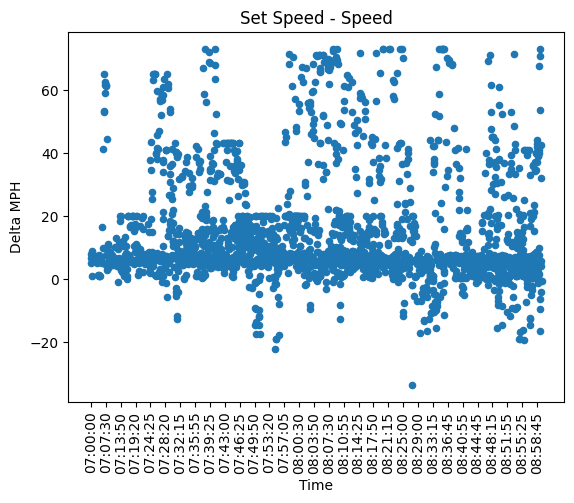

In [218]:
ax1 = df.plot(kind='scatter', x='Time',y=df.columns[2])
ax1.set_ylabel('Delta MPH')
ax1.set_title('Set Speed - Speed')
# Reduce the frequency of x-axis labels by selecting every nth label
n = 40  # Change this value to show every nth label
xticks = ax1.get_xticks()[::n]  # Select every nth tick
setticks = ax1.set_xticks(xticks)

# You can also optionally format the x-axis labels (e.g., rotating them)
ticklables = ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)

In [194]:
#########################
# Let's split that back into individual vehicle/date/run tracks
#########################
df2 = do_query(session, query)
column = (set(df2.columns)-{'Time','Device'}).pop()
df2 = df2.dropna(subset=[column])
df2 = df2.pivot(index='Time', columns='Device', values=column)
df2.reset_index(inplace=True)
df2['Time'] = (pd.to_datetime(df2['Time'], unit='us') - timedelta(hours=6)).dt.strftime('%H:%M:%S')


SELECT avg(acc_hub_set_speed) - avg(speed_speed)*0.621371
FROM root.circles100.vehicle_8*.2022_11_17.*
WHERE cruise_state_cruise_state > 0 and acc_hub_set_speed between 0 and 120
 group by ([2022-11-17T07:00:00,2022-11-17T08:59:59), 5s)  order by Time  align by device 

47520 records in 0.07284391694702208 seconds dataframe conversion in 0.08551504102069885 seconds


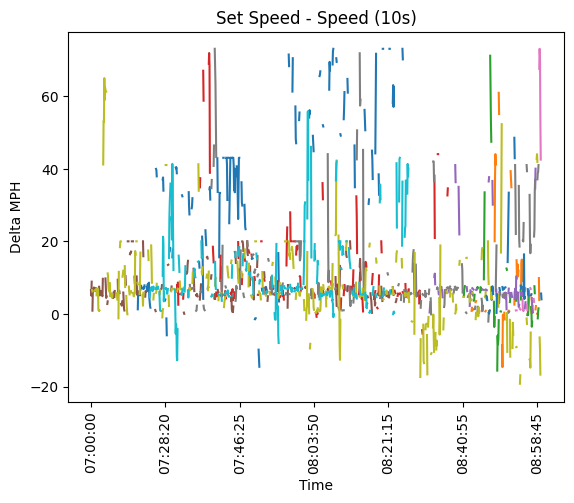

In [195]:
ax2 = df2.plot(x='Time',y=df2.columns[2:])
ax2.get_legend().remove()
ax2.set_ylabel('Delta MPH')
ax2.set_title('Set Speed - Speed (10s)')

setticks = ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)

In [196]:
#####################
# Find deceleration events (jerk)
#####################
query = f'''
SELECT derivative(derivative(avg (speed_speed))) as jerk
FROM root.circles100.*.2022_11_17.*
{groupby}{align}
'''
df3 = do_query(session, query)
column = (set(df3.columns)-{'Time','Device'}).pop()
df3 = df3.dropna(subset=[column])
min_row_index = df3[column].idxmin()
min_device = df3.loc[min_row_index, 'Device']
min_value = df3.loc[min_row_index, column]
min_time = df3.loc[min_row_index, 'Time']
df3 = df3.pivot(index='Time', columns='Device', values=(set(df3.columns)-{'Time','Device'}).pop())
df3.reset_index(inplace=True)
df3['Time'] = (pd.to_datetime(df3['Time'], unit='us') - timedelta(hours=6)).dt.strftime('%H:%M:%S')


SELECT derivative(derivative(avg (speed_speed))) as jerk
FROM root.circles100.*.2022_11_17.*
 group by ([2022-11-17T07:00:00,2022-11-17T08:59:59), 5s)  align by device 

433440 records in 0.07705254200845957 seconds dataframe conversion in 0.5408528329571709 seconds


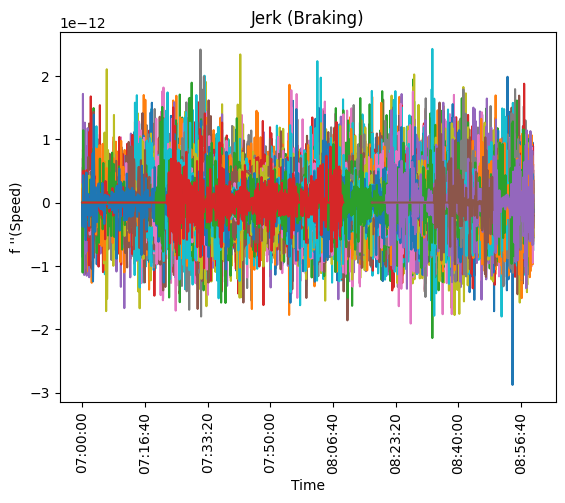

In [197]:
ax3 = df3.plot(x='Time',y=df3.columns[2:])
ax3.get_legend().remove()
ax3.set_ylabel('f \'\'(Speed)')
ax3t = ax3.set_title('Jerk (Braking)')
setticks = ax3.set_xticklabels(ax3.get_xticklabels(), rotation=90)

In [198]:
print(min_time, min_device, min_value)

1668696865000000 root.circles100.vehicle_36.2022_11_17.run_3 -2.8782105614423757e-12


In [199]:
#####################
# Find +/- 10s speed for vehicle isolated above
#####################
query = f'''
SELECT speed_speed*0.621371
FROM root.circles100.vehicle_83.2022_11_17.run_1
where Time between 1668695580000000 and 1668695600000000
'''
dfs = do_query(session, query)
dfs['Time'] = (pd.to_datetime(dfs['Time'], unit='us') - timedelta(hours=6)).dt.strftime('%H:%M:%S')


SELECT speed_speed*0.621371
FROM root.circles100.vehicle_83.2022_11_17.run_1
where Time between 1668695580000000 and 1668695600000000

1927 records in 0.0062716659740544856 seconds dataframe conversion in 0.0007611250039190054 seconds


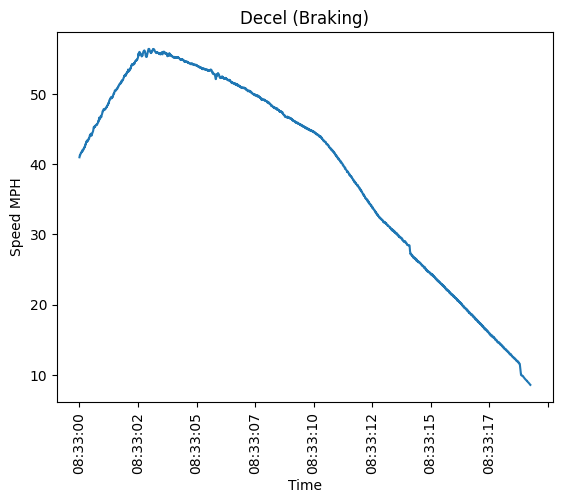

In [200]:
#display(dfs)
axs = dfs.plot(x='Time')
setticks = axs.set_xticklabels(axs.get_xticklabels(), rotation=90)
axst = axs.set_title('Decel (Braking)')
axs.set_ylabel('Speed MPH')
axs.get_legend().remove()

In [201]:
#####################
# Show traffic wave
#####################
query = f'''
SELECT avg(gps_data_Lat) as Lat, avg(gps_data_Long) as Long,
ABS(
    DEGREES(atan(
        abs(last_value(gps_data_Long)-first_value(gps_data_Long))
        /
        abs(last_value(gps_data_Lat)-first_value(gps_data_Lat))
    ))
    +jexl(
        (last_value(gps_data_Long)-first_value(gps_data_Long)),
        (last_value(gps_data_Lat)-first_value(gps_data_Lat)),
        'expr'='(x,y) -> (x < 0 && y >= 0 ? -360 : (x < 0 && y < 0 ? 180 : (x > 0 && y < 0 ? -180 : 0)))'
    )
) as Bearing
FROM root.circles100.*.2022_11_17.*
{groupby}{align}
'''
df4 = do_query(session, query)


SELECT avg(gps_data_Lat) as Lat, avg(gps_data_Long) as Long,
ABS(
    DEGREES(atan(
        abs(last_value(gps_data_Long)-first_value(gps_data_Long))
        /
        abs(last_value(gps_data_Lat)-first_value(gps_data_Lat))
    ))
    +jexl(
        (last_value(gps_data_Long)-first_value(gps_data_Long)),
        (last_value(gps_data_Lat)-first_value(gps_data_Lat)),
        'expr'='(x,y) -> (x < 0 && y >= 0 ? -360 : (x < 0 && y < 0 ? 180 : (x > 0 && y < 0 ? -180 : 0)))'
    )
) as Bearing
FROM root.circles100.*.2022_11_17.*
 group by ([2022-11-17T07:00:00,2022-11-17T08:59:59), 5s)  align by device 

478080 records in 0.17029212502529845 seconds dataframe conversion in 0.9780358339776285 seconds


In [202]:
# Get our nearest mile markers/distance
t1 = time.perf_counter()
df4 = spatial_interpolation(df4)
#df4 = gps2postmile(df4) #extraordinarily slow
t2 = time.perf_counter()
print(t2-t1)

0.031134916003793478


/var/folders/z3/b6dsdjkn5qngsp3tv6bwzck00000gn/T/ipykernel_12248/3103804197.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mile Marker'] = interpolated_mile_markers
/var/folders/z3/b6dsdjkn5qngsp3tv6bwzck00000gn/T/ipykernel_12248/3103804197.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Distance to Mile Marker'] = distances[:, 0] * 3959  # Take the smallest distance (first column of distances)


In [203]:
# Filter empty rows
df4 = df4.dropna(subset=['Lat', 'Long'])
# Filter to westbound
df4 = df4[(df4['Bearing'] > 270) | (df4['Bearing'] < 1)]
#display(df4)
# Filter by Mile Marker
df4 = df4[(df4['Mile Marker'] > 60.5) & (df4['Mile Marker'] < 64.3) & (df4['Distance to Mile Marker'] < 0.5)]
# Remove unneeded filter columns prior to plotting
del df4['Lat']
del df4['Long']
del df4['Bearing']
del df4['Distance to Mile Marker']
#display(df4)

In [204]:
df4 = df4.pivot(index='Time', columns='Device', values=(set(df4.columns)-{'Time','Device'}).pop())
df4.reset_index(inplace=True)
df4['Time'] = (pd.to_datetime(df4['Time'], unit='us') - timedelta(hours=6)).dt.strftime('%H:%M:%S')

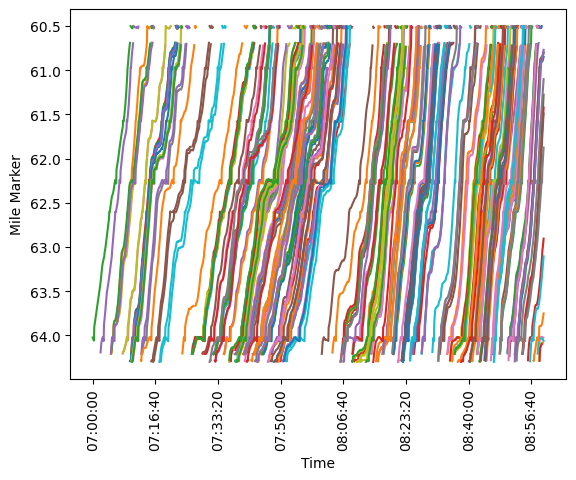

In [205]:
ax4 = df4.plot(x='Time',y=df4.columns[2:])
ax4.get_legend().remove()
ax4.invert_yaxis()
ax4.set_ylabel('Mile Marker')
setticks = ax4.set_xticklabels(ax4.get_xticklabels(), rotation=90)

In [206]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize
#####################
# Show traffic wave colorized
#####################
query = f'''
SELECT avg(gps_data_Lat) as Lat, avg(gps_data_Long) as Long, avg(speed_speed)*0.621371 as Speed,
ABS(
    DEGREES(atan(
        abs(last_value(gps_data_Long)-first_value(gps_data_Long))
        /
        abs(last_value(gps_data_Lat)-first_value(gps_data_Lat))
    ))
    +jexl(
        (last_value(gps_data_Long)-first_value(gps_data_Long)),
        (last_value(gps_data_Lat)-first_value(gps_data_Lat)),
        'expr'='(x,y) -> (x < 0 && y >= 0 ? -360 : (x < 0 && y < 0 ? 180 : (x > 0 && y < 0 ? -180 : 0)))'
    )
) as Bearing
FROM root.circles100.*.2022_11_17.*
{groupby}{align}
'''

df5 = do_query(session, query)


SELECT avg(gps_data_Lat) as Lat, avg(gps_data_Long) as Long, avg(speed_speed)*0.621371 as Speed,
ABS(
    DEGREES(atan(
        abs(last_value(gps_data_Long)-first_value(gps_data_Long))
        /
        abs(last_value(gps_data_Lat)-first_value(gps_data_Lat))
    ))
    +jexl(
        (last_value(gps_data_Long)-first_value(gps_data_Long)),
        (last_value(gps_data_Lat)-first_value(gps_data_Lat)),
        'expr'='(x,y) -> (x < 0 && y >= 0 ? -360 : (x < 0 && y < 0 ? 180 : (x > 0 && y < 0 ? -180 : 0)))'
    )
) as Bearing
FROM root.circles100.*.2022_11_17.*
 group by ([2022-11-17T07:00:00,2022-11-17T08:59:59), 5s)  align by device 

479520 records in 0.19887029199162498 seconds dataframe conversion in 1.4200865000020713 seconds


In [207]:
# Get our nearest mile markers/distance
df5 = spatial_interpolation(df5)
#df5 = gps2postmile(df5) #extraordinarily slow

/var/folders/z3/b6dsdjkn5qngsp3tv6bwzck00000gn/T/ipykernel_12248/3103804197.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mile Marker'] = interpolated_mile_markers
/var/folders/z3/b6dsdjkn5qngsp3tv6bwzck00000gn/T/ipykernel_12248/3103804197.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Distance to Mile Marker'] = distances[:, 0] * 3959  # Take the smallest distance (first column of distances)


In [208]:
df5 = filter_data(df5)

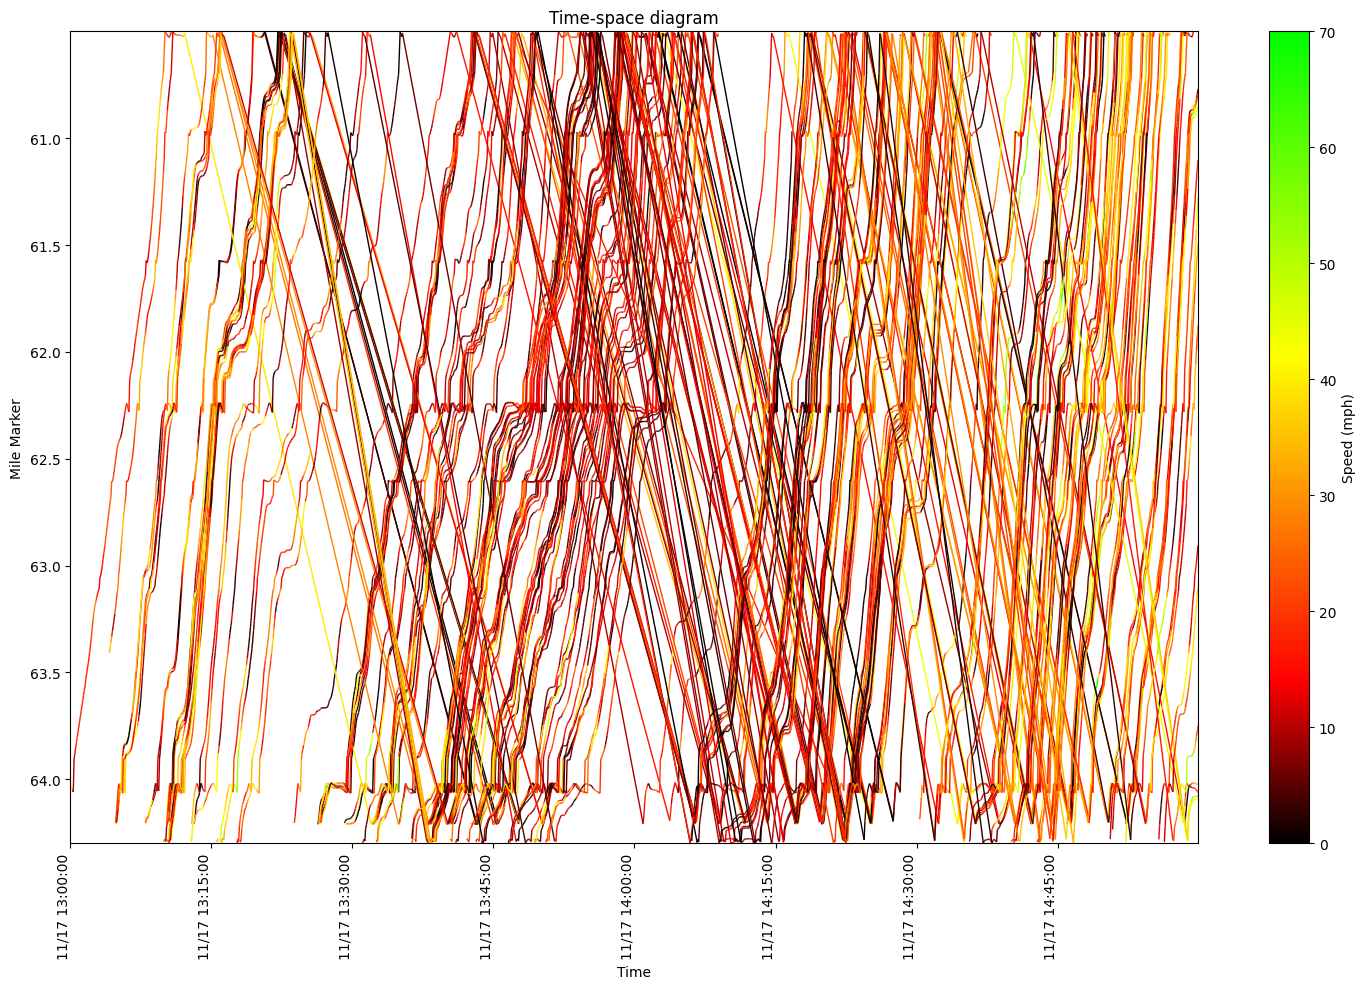

In [209]:
line_plot(df5)

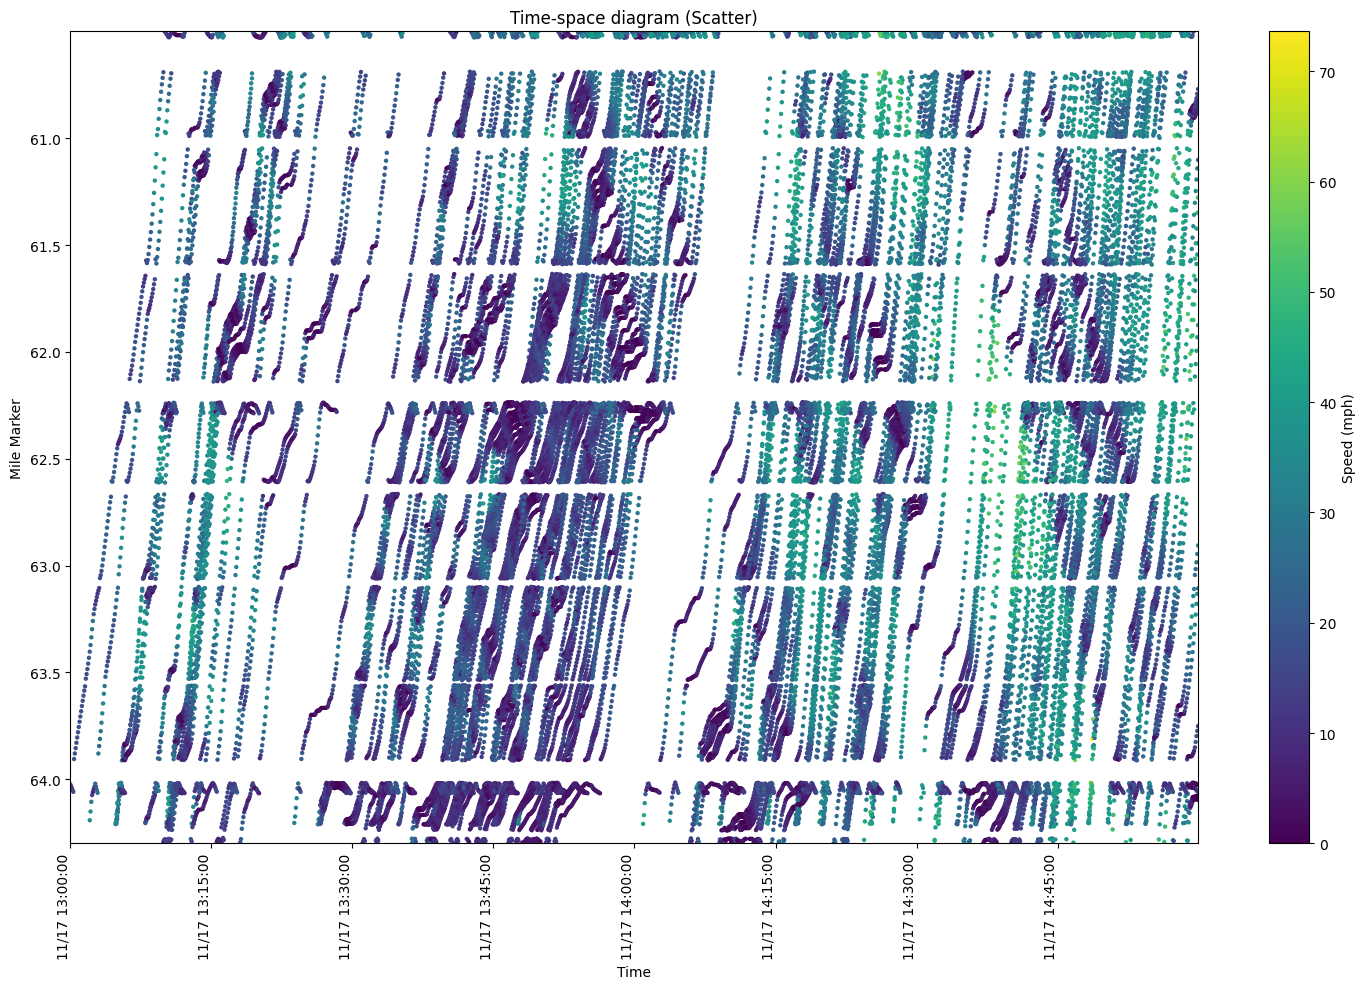

In [210]:
scatter_plot(df5)

In [233]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize
#####################
# Show traffic wave colorized
#####################
query = f'''
SELECT 
    first_value(gps_data_Lat) as Lat1,
    last_value(gps_data_Lat) as Lat2, 
    first_value(gps_data_Long) as Lon1,
    last_value(gps_data_Long) as Lon2,
    avg(speed_speed)*0.621371 as Speed
FROM root.circles100.*.2022_11_17.*
{groupby}{align}
'''

df6 = do_query(session, query)


SELECT 
    first_value(gps_data_Lat) as Lat1,
    last_value(gps_data_Lat) as Lat2, 
    first_value(gps_data_Long) as Lon1,
    last_value(gps_data_Long) as Lon2,
    avg(speed_speed)*0.621371 as Speed
FROM root.circles100.*.2022_11_17.*
 group by ([2022-11-17T07:00:00,2022-11-17T08:59:59), 5s)  align by device 

479520 records in 0.09445595799479634 seconds dataframe conversion in 1.3445677499985322 seconds


In [234]:
df6 = spatial_interpolation2(df6)
#display(df6)

In [235]:
df6 = filter_data(df6,NaN=True)
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.expand_frame_repr', False)
#display(df6)

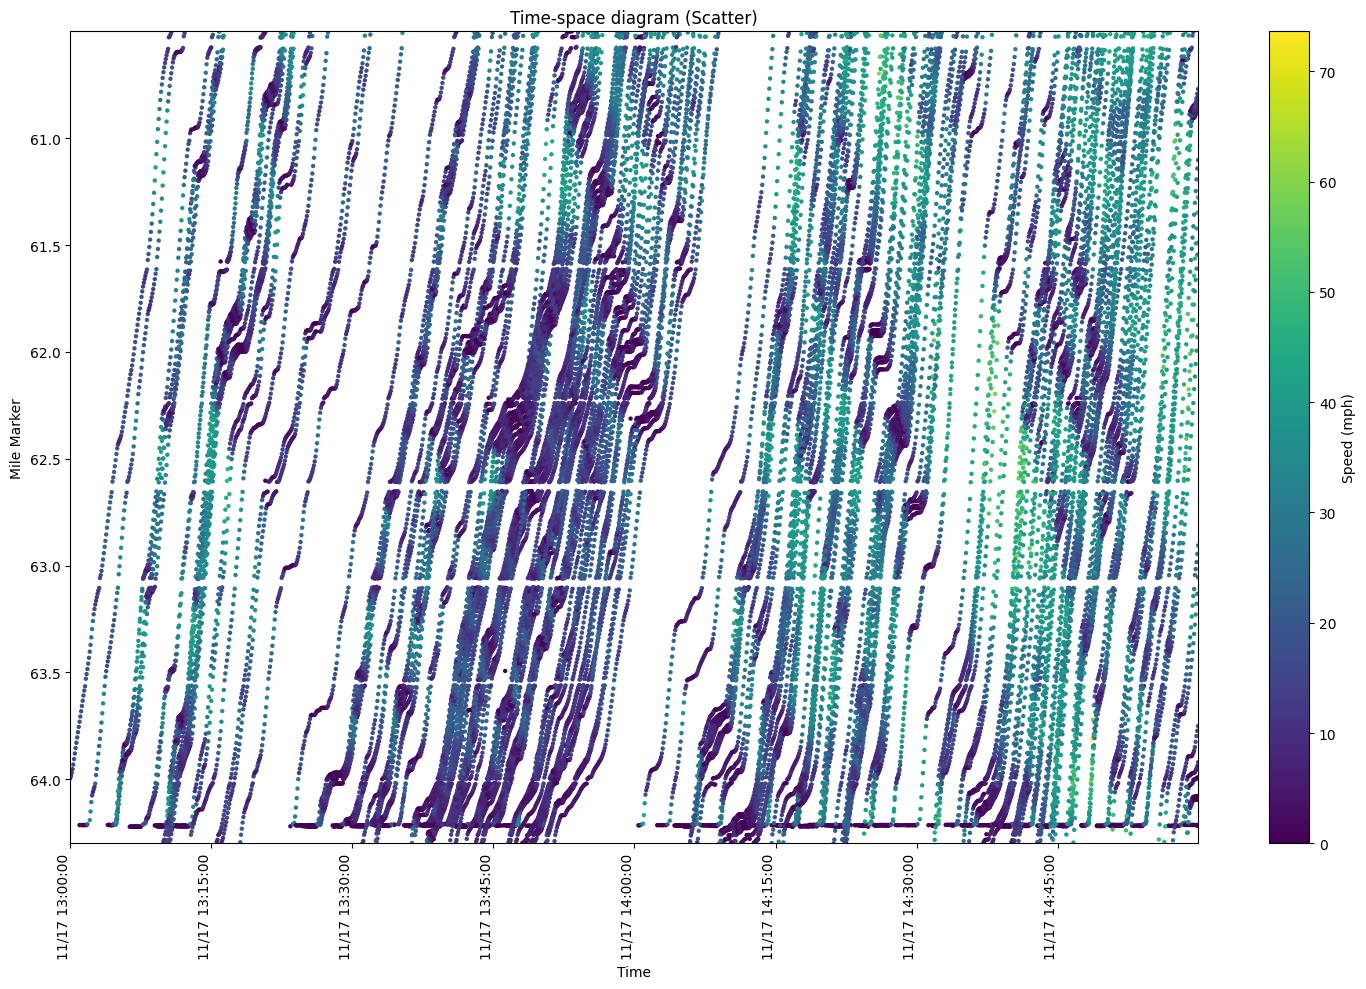

In [236]:
scatter_plot(df6)


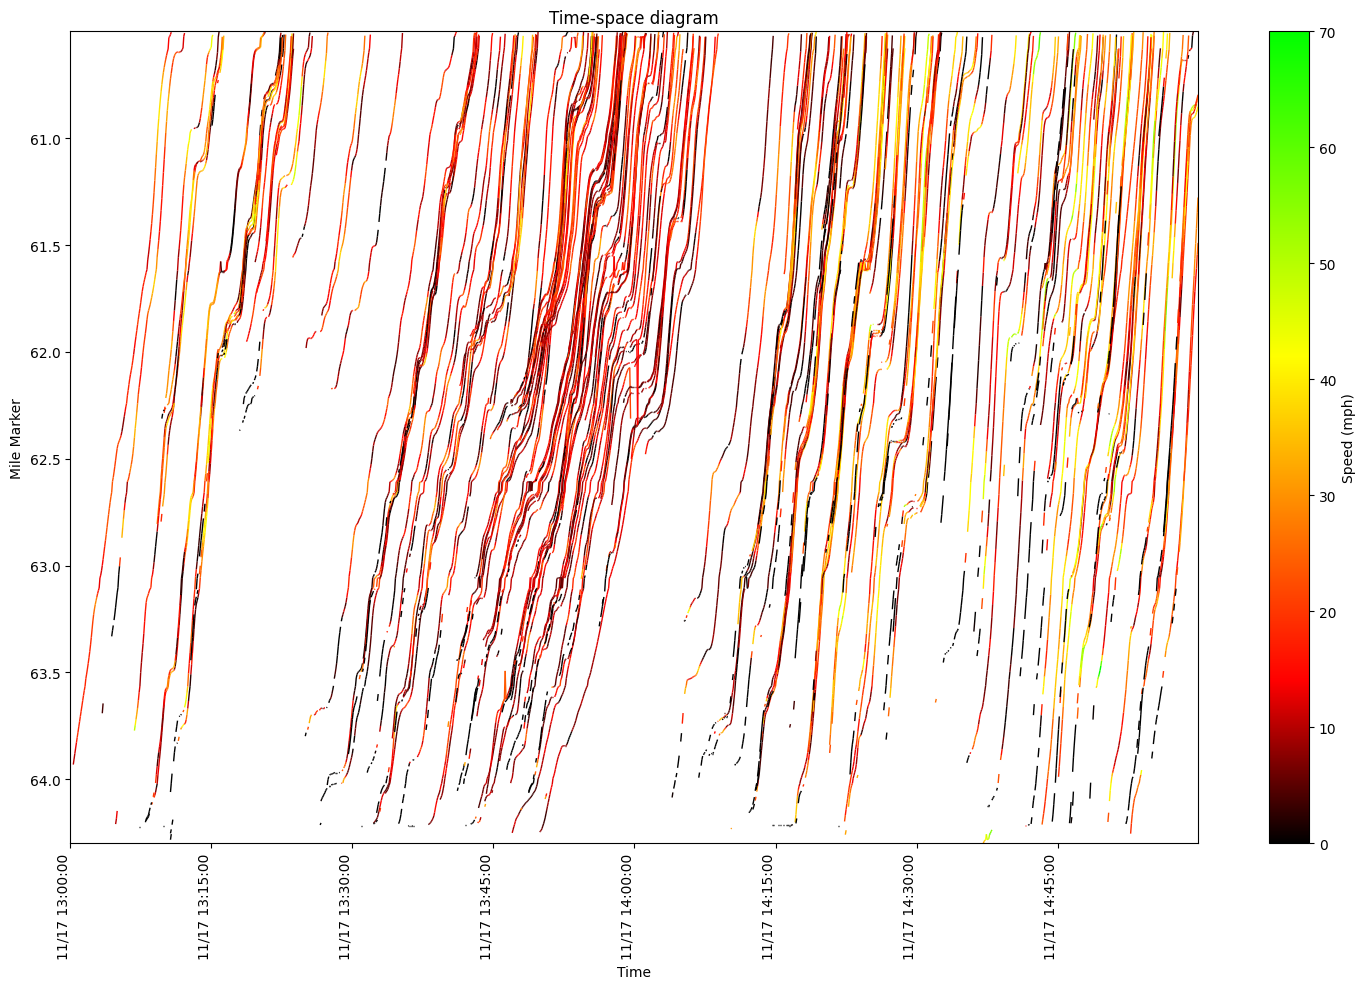

In [237]:
line_plot(df6)